<h1>1. Import</h1>

In [1]:
#import des librairies
%pylab inline
import numpy as np 
import pandas as pd 
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
import re
from textblob import TextBlob
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.svm import SVC
import sklearn.naive_bayes as nb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import plot_importance, to_graphviz
from collections import Counter
from sklearn.metrics import confusion_matrix, accuracy_score, auc, precision_score, recall_score
from sklearn import feature_extraction, model_selection, svm
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from sklearn.decomposition import TruncatedSVD
from gensim.utils import tokenize
from gensim.models import word2vec

Populating the interactive namespace from numpy and matplotlib


In [2]:
#pip install -U gensim

In [3]:
#pip install xgboost

In [4]:
#ignore les warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
#chargement des données
#remplacement de None par NaN
#décimal avec un point plutôt qu'une virgule dans le dataframe afin que les variables soient de type float
df = pd.read_csv(r"C:\Users\utilisateur\Documents\Projet\ProjetNLP\booking.csv", na_values=['None'], decimal=',')

In [6]:
#affichage des 5 premières lignes du dataframe
df.head()

,nom,pays,favorite,date,titre,bons_points,mauvais_points,note,type_etablissement,lieu,note_etablissement
0,Caroline,Belgique,1.0,2018-07-30 00:00:00,Exceptionnel,"Établissement recent, propre, soigne, chouette...",Rien,10.0,Hôtel,Paris,8.5
1,Olivier51,France,0.0,2020-03-16 00:00:00,Fabuleux,"Accueil très chaleureux, chambre calme...tout ...",NaN,9.0,Hôtel,Paris,8.5
2,Marc,France,0.0,2020-03-11 00:00:00,Exceptionnel,Tout bié sauf le wifi catastrophiquement lent!...,NaN,9.6,Hôtel,Paris,8.5
3,Marie-claire,France,0.0,2020-03-08 00:00:00,Exceptionnel,NaN,Hôtel parfait. Quartier sympa.,10.0,Hôtel,Paris,8.5
4,Pierre,France,0.0,2020-03-06 00:00:00,Fabuleux,Excellent rapport qualité prix. Personnel très...,NaN,9.0,Hôtel,Paris,8.5


<h1>2. Exploration et nettoyage des données</h1>

In [7]:
#dimensions du dataframe
print('Le dataset a {} lignes et {} colonnes.'.format(df.shape[0], df.shape[1]))

Le dataset a 30946 lignes et 11 colonnes.


In [8]:
#affichage des variables
print('Les différents types de variables sont : {}.'.format(df.columns.tolist()))

Les différents types de variables sont : ['nom', 'pays', 'favorite', 'date', 'titre', 'bons_points', 'mauvais_points', 'note', 'type_etablissement', 'lieu', 'note_etablissement'].


In [9]:
#Existe-t-il des variables non renseignées?
df.isnull().values.any()

True

In [10]:
#affichage du nombre de valeurs manquantes selon chaque variable
df.isnull().sum()

nom                    395
pays                   452
favorite                15
date                   410
titre                  432
bons_points           2359
mauvais_points        8540
note                   410
type_etablissement      15
lieu                    15
note_etablissement      15
dtype: int64

In [11]:
#type de chaque variable
df.dtypes

nom                    object
pays                   object
favorite               object
date                   object
titre                  object
bons_points            object
mauvais_points         object
note                  float64
type_etablissement     object
lieu                   object
note_etablissement    float64
dtype: object

In [12]:
#statistiques descriptives du dataset
df.describe(include='all')

,nom,pays,favorite,date,titre,bons_points,mauvais_points,note,type_etablissement,lieu,note_etablissement
count,30551,30494,30931,30536,30514,28587,22406,30536.000000,30931,30931,30931.000000
unique,5838,127,2,1246,9611,22578,18151,NaN,11,18,NaN
top,Anonyme,France,0.0,2020-02-16 00:00:00,Bien,Ce client n'a pas laissé de commentaire.,Rien,NaN,Hôtel,Paris,NaN
freq,650,25991,30211,205,4763,1502,833,NaN,25927,12888,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.977607,NaN,NaN,7.903485
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.396143,NaN,NaN,0.701262
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,5.300000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.100000,NaN,NaN,7.300000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.000000,NaN,NaN,8.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.000000,NaN,NaN,8.400000


In [13]:
#suppression des accents
cols = df.select_dtypes(include=[np.object]).columns
df[cols] = df[cols].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))
df

,nom,pays,favorite,date,titre,bons_points,mauvais_points,note,type_etablissement,lieu,note_etablissement
0,Caroline,Belgique,1.0,2018-07-30 00:00:00,Exceptionnel,"Etablissement recent, propre, soigne, chouette...",Rien,10.0,Hotel,Paris,8.5
1,Olivier51,France,0.0,2020-03-16 00:00:00,Fabuleux,"Accueil tres chaleureux, chambre calme...tout ...",NaN,9.0,Hotel,Paris,8.5
2,Marc,France,0.0,2020-03-11 00:00:00,Exceptionnel,Tout bie sauf le wifi catastrophiquement lent!...,NaN,9.6,Hotel,Paris,8.5
3,Marie-claire,France,0.0,2020-03-08 00:00:00,Exceptionnel,NaN,Hotel parfait. Quartier sympa.,10.0,Hotel,Paris,8.5
4,Pierre,France,0.0,2020-03-06 00:00:00,Fabuleux,Excellent rapport qualite prix. Personnel tres...,NaN,9.0,Hotel,Paris,8.5
...,...,...,...,...,...,...,...,...,...,...,...
30941,Pierre,France,0.0,2019-09-17 00:00:00,Exceptionnel,L'hotel est agreable et confortable. Tres bonn...,C'est regrettable de ne pas avoir de plateau d...,10.0,Appart'hotel,Toulouse,8.5
30942,Carima,France,0.0,2019-09-15 00:00:00,Exceptionnel,"La chambre, le personnel au top et surtout le ...",Rien tout etais au top! Merci!,10.0,Appart'hotel,Toulouse,8.5
30943,Clarys,France,0.0,2019-09-13 00:00:00,Hotel tres confortable,"La chambre, ses equipements, le pdj et l hotel...",Rien,10.0,Appart'hotel,Toulouse,8.5
30944,Jean,France,0.0,2019-09-13 00:00:00,Deja utilise plusieurs fois,Salle claire,NaN,9.6,Appart'hotel,Toulouse,8.5


In [14]:
#fonction pour générer un nuage de mots
def wcloud(data,bgcolor,title):
    plt.figure(figsize = (100,100))
    wc = WordCloud(background_color = bgcolor, max_words = 1000,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

In [15]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\utilisateur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
df.drop(['nom', 'pays', 'favorite', 'date', 'note', 'type_etablissement', 'lieu', 'note_etablissement'],1,inplace=True)
df.head()

,titre,bons_points,mauvais_points
0,Exceptionnel,"Etablissement recent, propre, soigne, chouette...",Rien
1,Fabuleux,"Accueil tres chaleureux, chambre calme...tout ...",NaN
2,Exceptionnel,Tout bie sauf le wifi catastrophiquement lent!...,NaN
3,Exceptionnel,NaN,Hotel parfait. Quartier sympa.
4,Fabuleux,Excellent rapport qualite prix. Personnel tres...,NaN


In [17]:
df1 = pd.DataFrame(columns = ['titre', 'bons_points', 'mauvais_points'])

In [18]:
#mettre tous les éléments en miniscule, séparés par un espace
a = df['titre'].str.lower().str.cat(sep=' ')

#supprimer ponctuation, nombres and retourner une liste de mots
b = re.sub('[^A-Za-z]+', ' ', a)

#supprimer tous les mots "vides" du texte
stop_words = list(get_stop_words('french'))         
nltk_words = list(stopwords.words('french'))   
stop_words.extend(nltk_words)

word_tokens = word_tokenize(b)
filtered_sentence = [w for w in word_tokens if not w in stop_words]
filtered_sentence = []
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)

#supprimer les mots qui ont une longueur inférieure à 2  
without_single_chr = [word for word in filtered_sentence if len(word) > 2]

In [19]:
#suppression des caractères numériques
cleaned_data = [word for word in without_single_chr if not word.isnumeric()]        

#calculer les 100 mots les plus fréquents
top_N = 100
word_dist = nltk.FreqDist(cleaned_data)
rslt = pd.DataFrame(word_dist.most_common(top_N), columns=['Word', 'Frequency'])

In [20]:
rslt.head(7)

,Word,Frequency
0,bien,10137
1,tres,6286
2,agreable,3299
3,sejour,2884
4,exceptionnel,2654
5,hotel,2036
6,fabuleux,1827


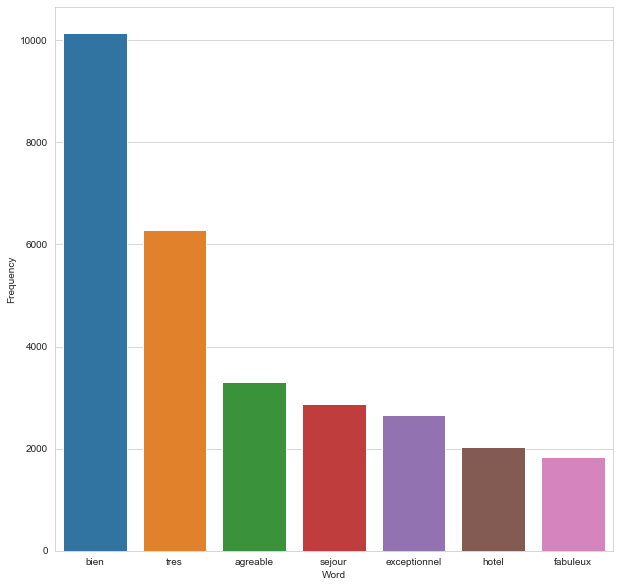

In [21]:
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(7))

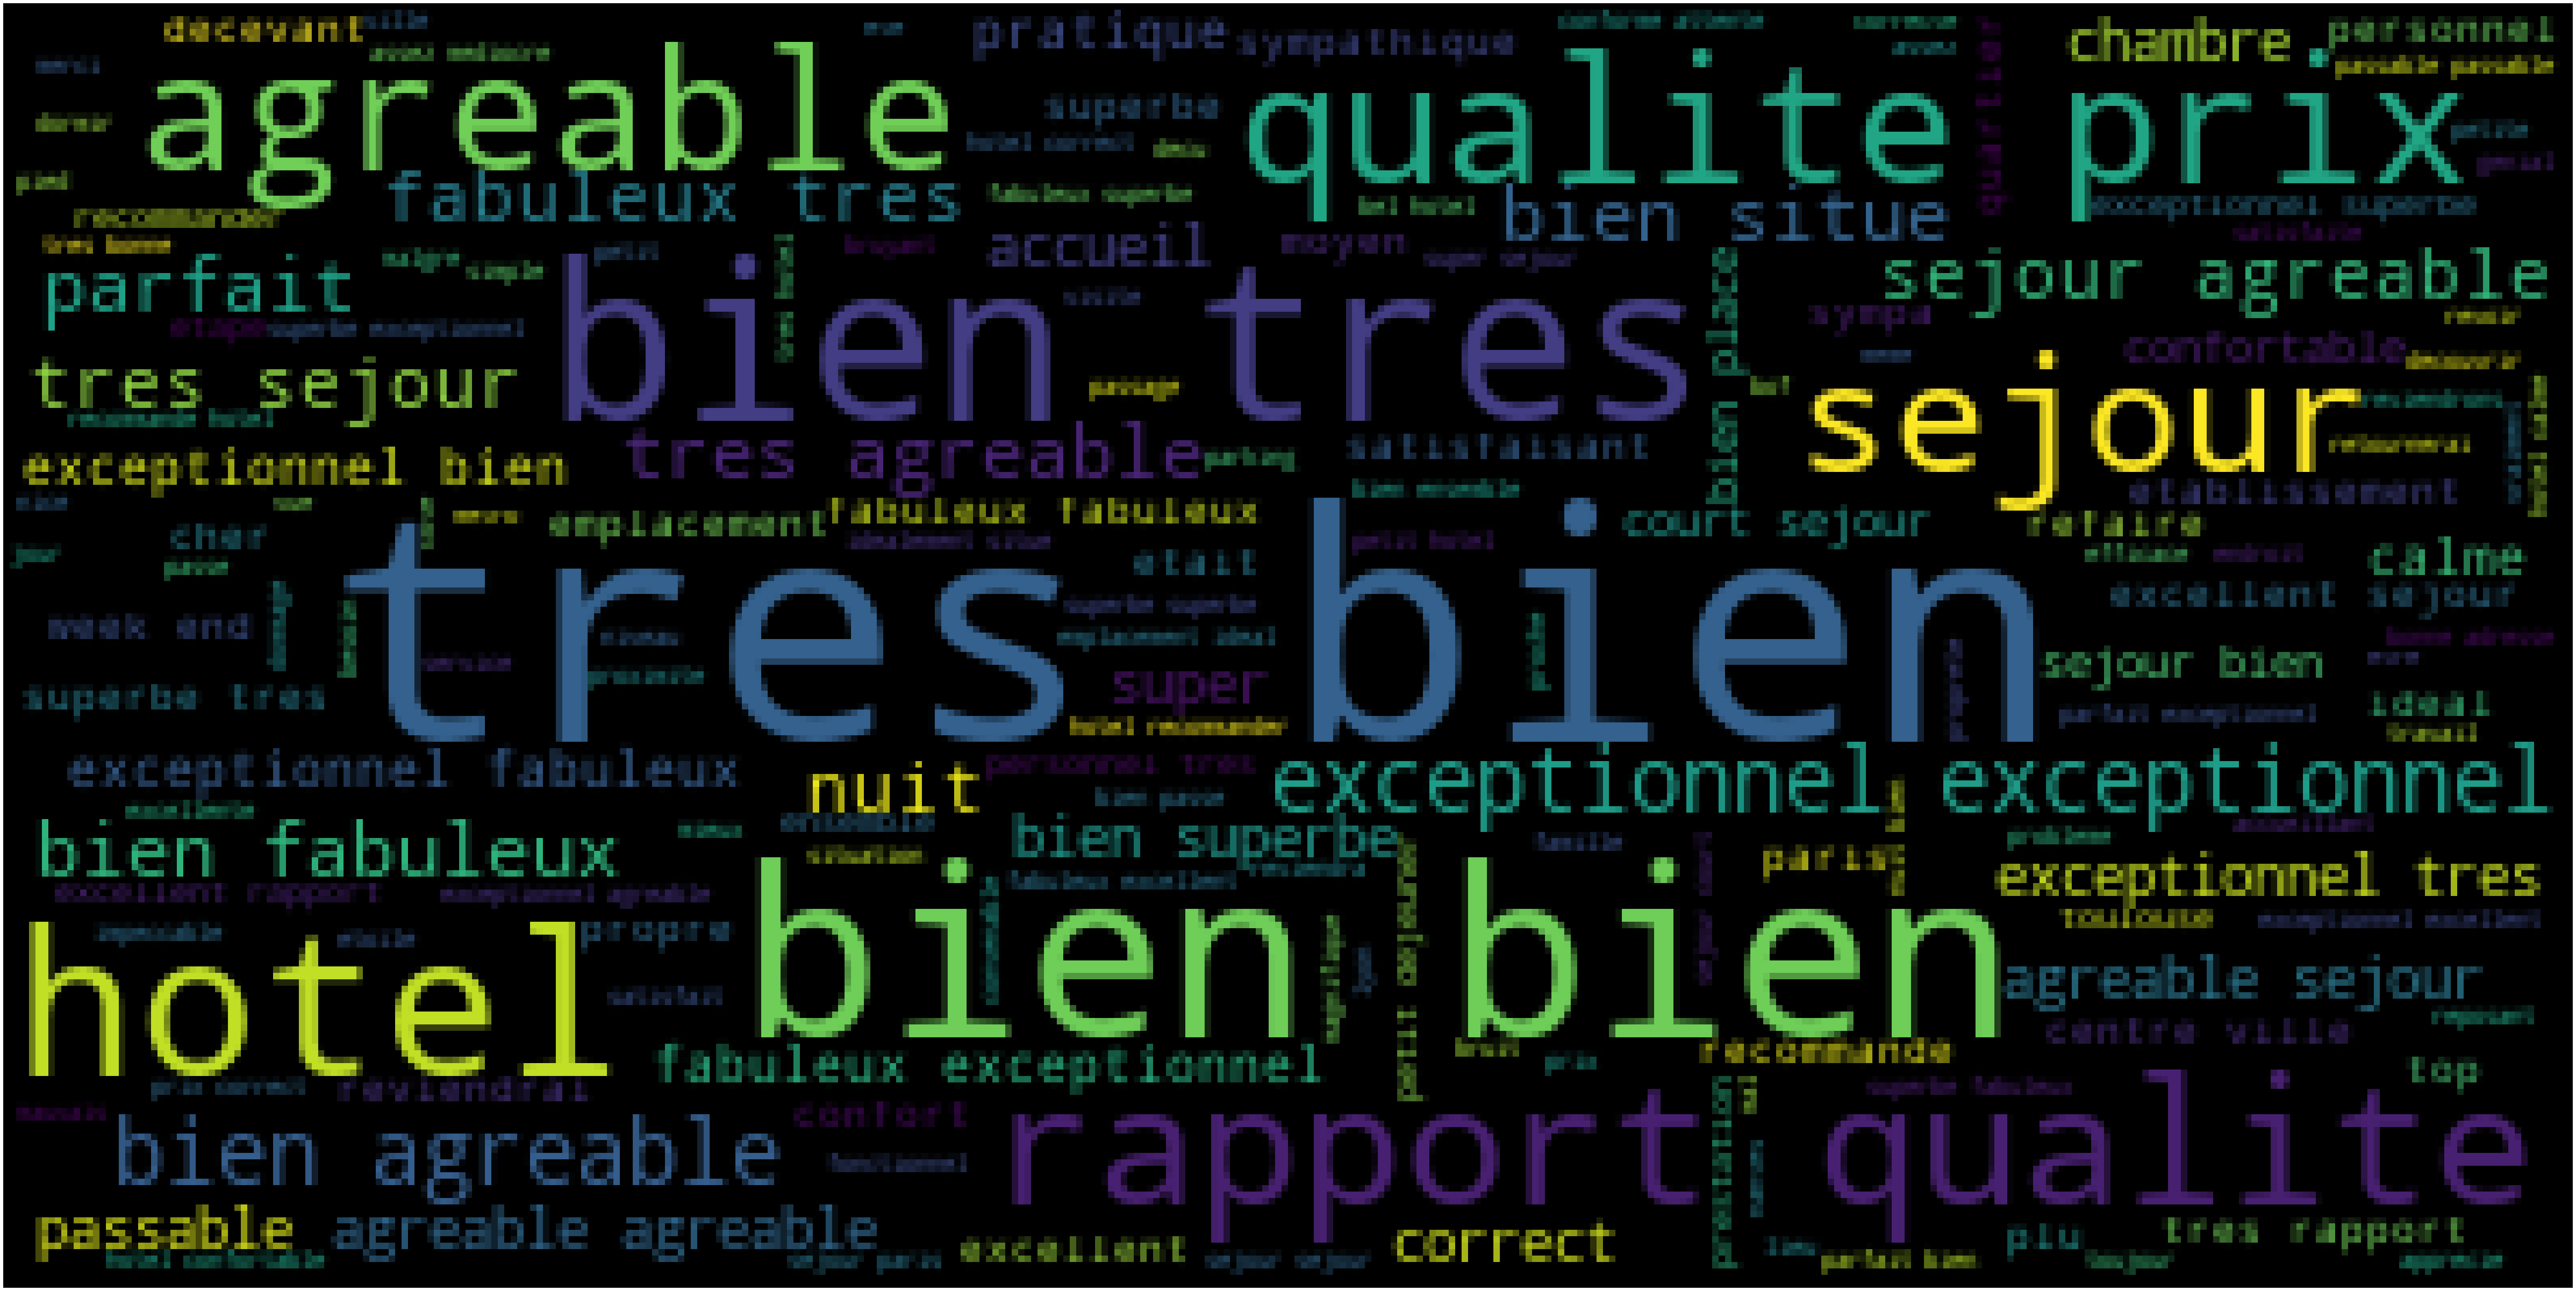

In [22]:
#nuage de mots
wcloud(cleaned_data,'black','Common Words')

In [23]:
#mettre tous les éléments en miniscule, séparés par un espace
a = df['bons_points'].str.lower().str.cat(sep=' ')

#supprimer ponctuation, nombres and retourner une liste de mots
b = re.sub('[^A-Za-z]+', ' ', a)

#supprimer tous les mots "vides" du texte
stop_words = list(get_stop_words('french'))         
nltk_words = list(stopwords.words('french'))   
stop_words.extend(nltk_words)

word_tokens = word_tokenize(b)
filtered_sentence = [w for w in word_tokens if not w in stop_words]
filtered_sentence = []
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)

#supprimer les mots qui ont une longueur inférieure à 2  
without_single_chr = [word for word in filtered_sentence if len(word) > 2]

In [24]:
#supprimer les caractères numériques
cleaned_data = [word for word in without_single_chr if not word.isnumeric()]        

#calculer les 100 mots les plus fréquents
top_N = 100
word_dist = nltk.FreqDist(cleaned_data)
rslt = pd.DataFrame(word_dist.most_common(top_N), columns=['Word', 'Frequency'])

In [25]:
rslt.head(7)

,Word,Frequency
0,tres,12579
1,personnel,7096
2,petit,6658
3,chambre,6588
4,dejeuner,5733
5,bien,5126
6,accueil,4242


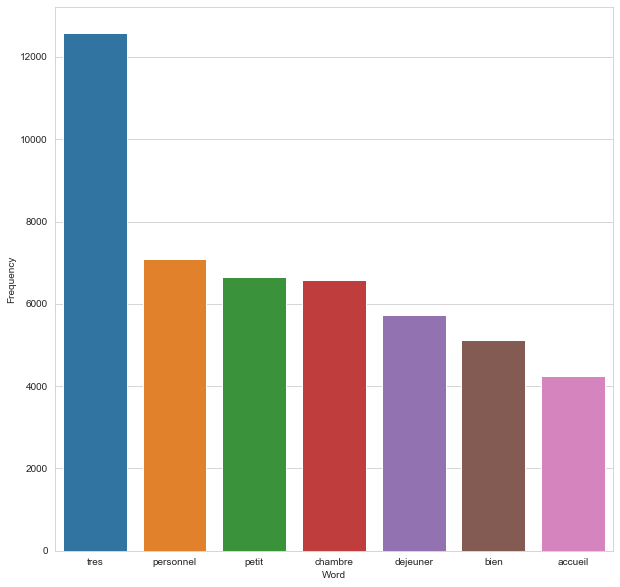

In [26]:
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(7))

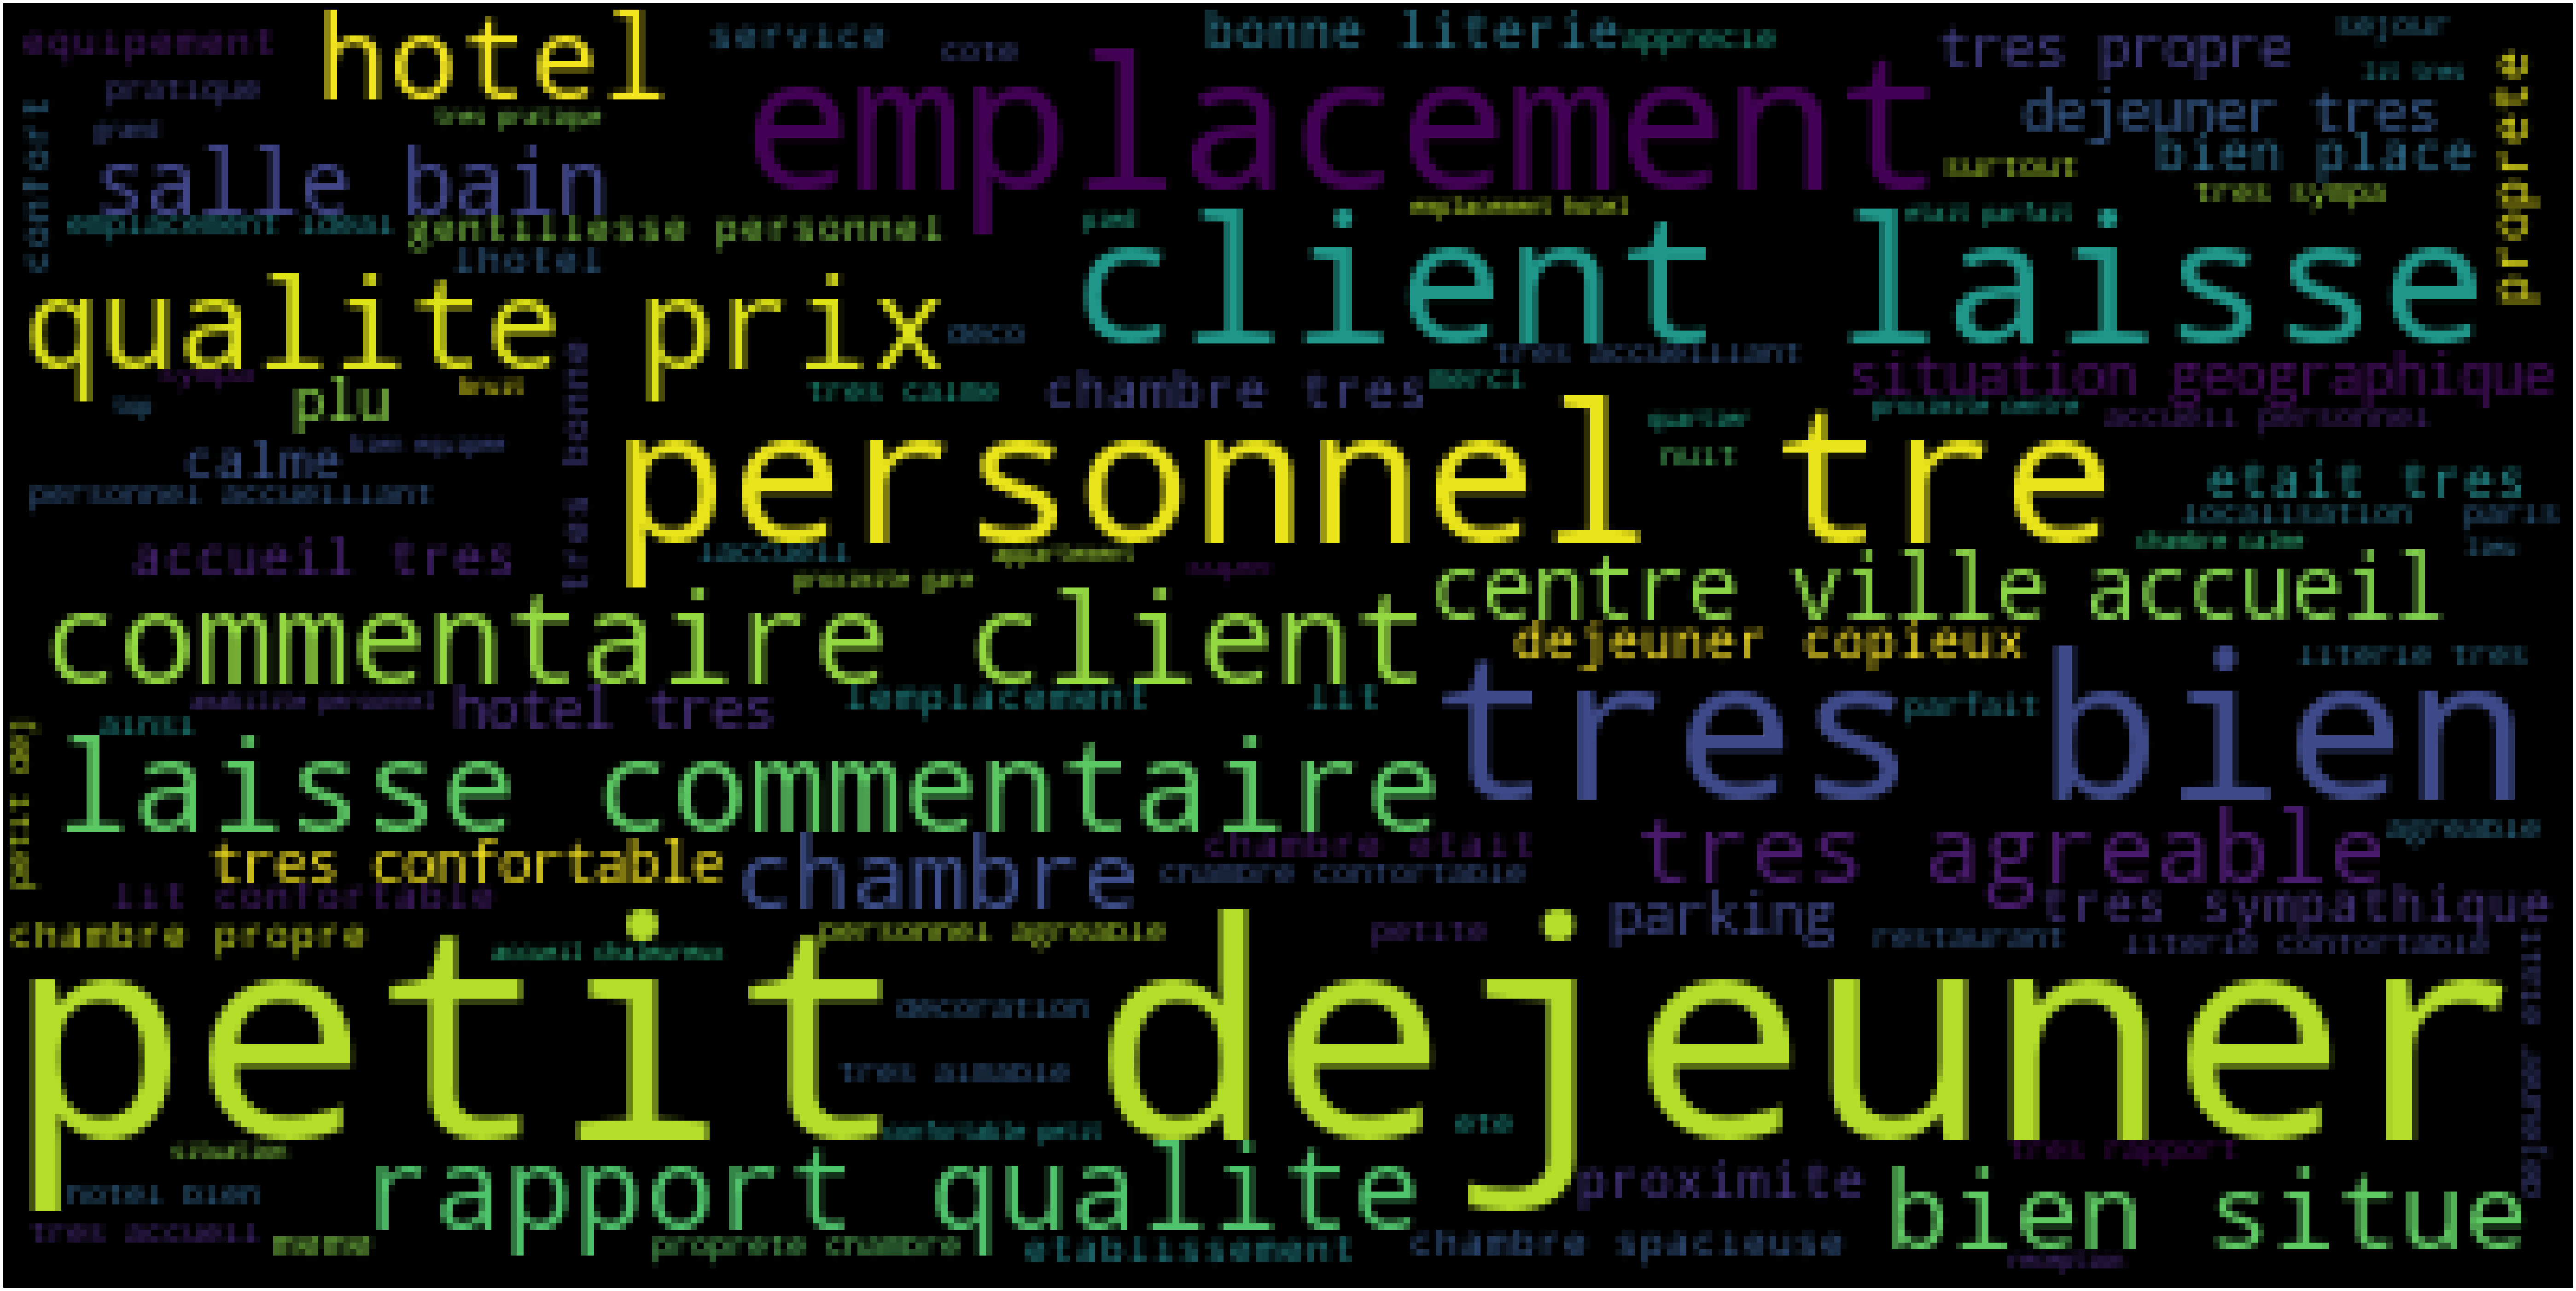

In [27]:
#nuage de mots
wcloud(cleaned_data,'black','Common Words')

In [28]:
#mettre tous les éléments en miniscule, séparés par un espace
a = df['mauvais_points'].str.lower().str.cat(sep=' ')

#supprimer ponctuation, nombres and retourner une liste de mots
b = re.sub('[^A-Za-z]+', ' ', a)

#supprimer tous les mots "vides" du texte
stop_words = list(get_stop_words('french'))         
nltk_words = list(stopwords.words('french'))   
stop_words.extend(nltk_words)

word_tokens = word_tokenize(b)
filtered_sentence = [w for w in word_tokens if not w in stop_words]
filtered_sentence = []
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)

#supprimer les mots qui ont une longueur inférieure à 2  
without_single_chr = [word for word in filtered_sentence if len(word) > 2]

In [29]:
#supprimer caractères numériques
cleaned_data = [word for word in without_single_chr if not word.isnumeric()]        

#calculer les 100 mots les plus fréquents
top_N = 100
word_dist = nltk.FreqDist(cleaned_data)
rslt = pd.DataFrame(word_dist.most_common(top_N), columns=['Word', 'Frequency'])

In [30]:
rslt.head(7)

,Word,Frequency
0,chambre,6337
1,tres,4117
2,petit,3381
3,salle,3138
4,dejeuner,2440
5,bain,2243
6,etait,2131


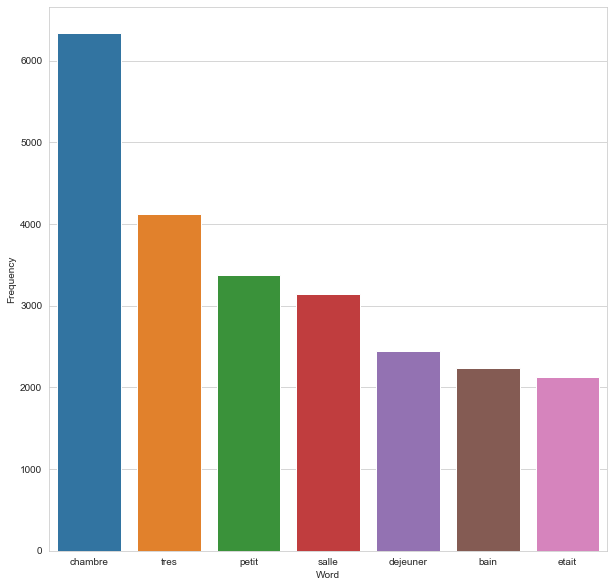

In [31]:
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(7))

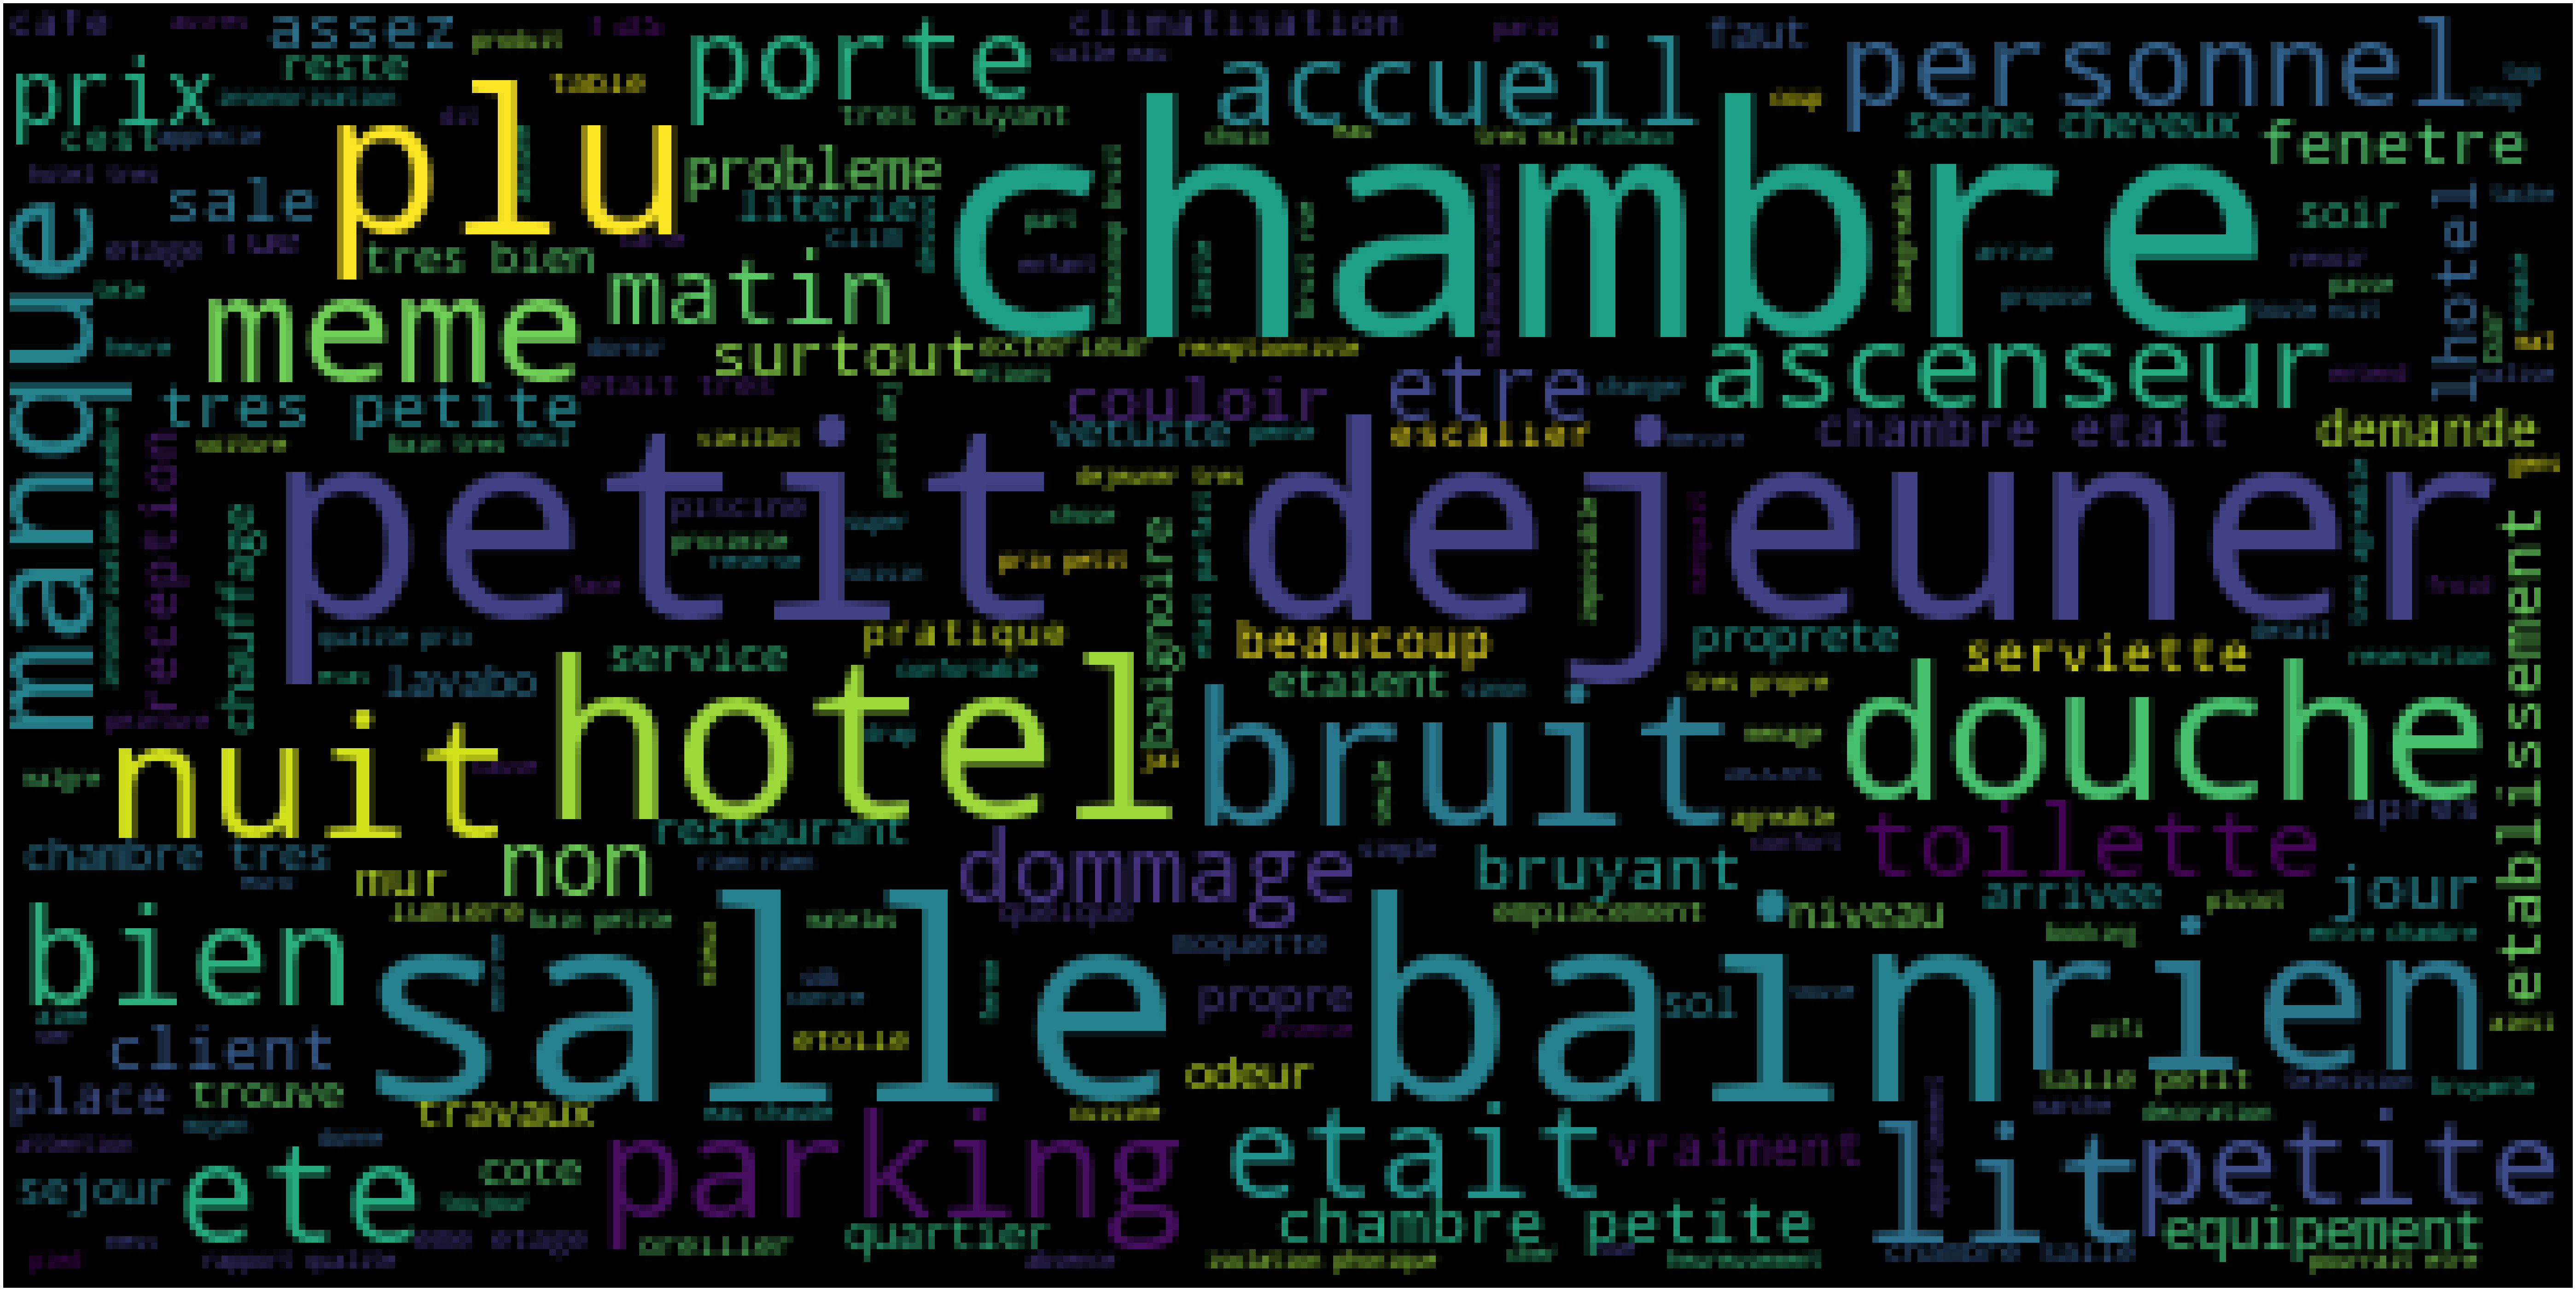

In [32]:
#nuage de mots
wcloud(cleaned_data,'black','Common Words')

In [33]:
#vérification que les NaN dans la colonne 'mauvais points' ont bien de façon certaine une polarité de zéro pour TextBlob, 
#sentiment[0]=polarite et sentiment[1]=subjectivité
text = u"NaN"
blob = TextBlob(text, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
blob.sentiment
print('NaN a une polarité de {} et une subjectivité de {}.'.format(blob.sentiment[0], blob.sentiment[1]))

NaN a une polarité de 0.0 et une subjectivité de 0.0.


In [34]:
#chargement du dataframe pour avoir de nouveau les accents
df = pd.read_csv(r"C:\Users\utilisateur\Desktop\booking.csv", na_values=['None'], decimal=',')

# Mettre tous les éléments en miniscule
def en_minuscule(x):
"""Fonction qui met le texte en minuscule"""
return x.str.lower()

df = df.apply(en_minuscule)
df.head(100)

# Supprimer ponctuation, nombres
for col in df:
df[col] = df[col].str.replace('[^A-Za-z]+', ' ', regex=True)
df.head(100)

# Supprimer les caractères numériques
for col in df:
df[col] = df[col].str.replace('\d+', '', regex=True)
df.head(100)

# Supprimer les mots qui ont une longueur inférieure à 2
def garde_mot_sup_2_car(x):
""" Fonction qui ne garde que les mots supérieurs à 2 caractères """
chaine = ''
print(x)
if type(x) is str:
splitted_chain = x.split(' ')
for word in splitted_chain:
if len(word) > 2:
chaine += word + ' '
print(chaine)
return chaine
elif type(x) is int or float:
if np.isnan(x):
return x

for col in df:
df[col] = df[col].apply(garde_mot_sup_2_car)
df.head(100)

# [TODO]supprimer tous les mots "vides" du texte

for sentences in comments :
    aa = comments[sentences]
#print(aa)

for index, row in comments.iterrows():
    aa = row['sentences']
    
    stop_words = list(get_stop_words('french'))         
    nltk_words = list(stopwords.words('french'))   
    stop_words.extend(nltk_words)
    word_tokens = word_tokenize(aa)
#    print(word_tokens)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = []
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
    #supprimer les mots qui ont une longueur inférieure à 2  
    without_single_chr = [word for word in filtered_sentence if len(word) > 2]
        
    #suppression des caractères numériques
    cleaned_data = [word for word in without_single_chr if not word.isnumeric()]
    comments.append(cleaned_data, ignore_index=True)

In [35]:
df = df.loc[df['type_etablissement'] == 'Hôtel']
#print(df_clean_hotel.shape)

df = df[df.bons_points != "Ce commentaire n'apparaît pas car il ne respecte pas notre charte."]
#print(df_clean_hotel_censur_bp.shape)
df = df[df.bons_points != "Ce client n'a pas laissé de commentaire."]
#print(df_clean_hotel_censur_bp.shape)


df = df[df.mauvais_points != "Ce commentaire n'apparaît pas car il ne respecte pas notre charte."]
#print(df_clean_hotel_censur_mp.shape)
df = df[df.mauvais_points != "Ce client n'a pas laissé de commentaire."]
#print(df_clean_hotel_censur_bp.shape)

In [36]:
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
df22 = pd.DataFrame(df, columns= ['titre', 'bons_points', 'mauvais_points'])

df21 = df22['titre'].map(str) + ' ' + df22['bons_points'].map(str) + ' ' + df22['mauvais_points'].map(str)

print(df21)

bloblist_desc = list()

df_str=df21.astype(str)
for row in df_str:
    blob = TextBlob(row)
    #print(blob)
    pos_tagger=PatternTagger()
    analyzer=PatternAnalyzer()
    blob = tb(str(blob)) #textblob
    #sentiment renvoie un tuple avec la polarité et la subjectivite
    #print(blob.sentiment[0])
    #type(blob.sentiment[0])
    bloblist_desc.append(blob.sentiment[0])
    #df_polarity_desc1 = pd.DataFrame(bloblist_desc, columns = ['sentiment'])

0      Le confort comme à la maison ! J'ai énormément...
1      Calme et confortable. Très bon accueil, Hatim ...
2      Accueil chaleureux - Personnel irréprochable :...
3      Très correct Merci a Hatim pour l'accueil, trè...
4      Très bien L’accueil , la situation de l’établi...
                             ...                        
238    Exceptionnel Très bon accueil, chambre impecca...
239    Je recommande Le personnel est super sympathiq...
240    Adresse à conseiller Emplacement excellent pro...
241    Demander si la chambre est climatisée L'accuei...
242    Agréable L’accueil, l’amabilité et la réactivi...
Length: 243, dtype: object


In [37]:
df_polarity_desc1 = pd.DataFrame(data = bloblist_desc)
df_polarity_desc1.columns = ['sentiment']
df_polarity_desc1.head()

,sentiment
0,0.285000
1,0.354286
2,0.015833
3,0.343750
4,0.000000


In [38]:
def f(df_polarity_desc1):
    if df_polarity_desc1['sentiment'] > 0:
        val = "positive"
    elif df_polarity_desc1['sentiment'] < 0:
        val = "negative"
    else :
        val = "neutre"
    return val

df_polarity_desc1.apply(f, axis=1)

0      positive
1      positive
2      positive
3      positive
4        neutre
         ...   
238    positive
239    positive
240    positive
241    negative
242    positive
Length: 243, dtype: object

In [39]:
df_polarity_desc1['polarite']=df_polarity_desc1.apply(f, axis=1)

In [40]:
df_polarity_desc1.head()

,sentiment,polarite
0,0.285000,positive
1,0.354286,positive
2,0.015833,positive
3,0.343750,positive
4,0.000000,neutre


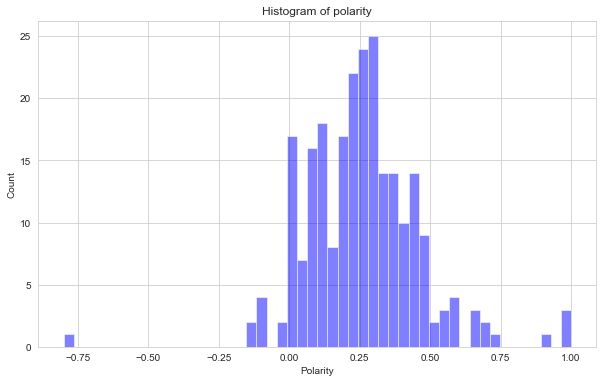

In [41]:
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(df_polarity_desc1.sentiment, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Histogram of polarity')
plt.show();

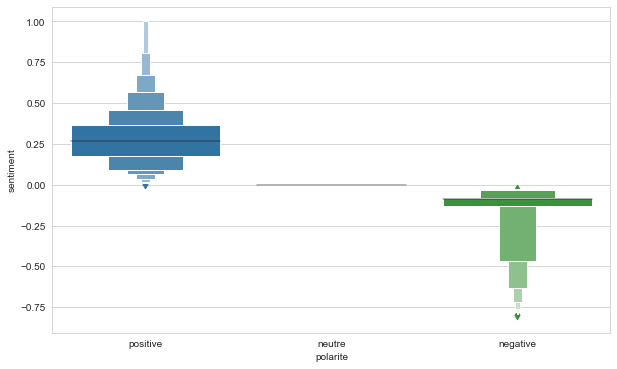

In [42]:
plt.figure(figsize=(10,6))
sns.boxenplot(x='polarite', y='sentiment', data=df_polarity_desc1)
plt.show();

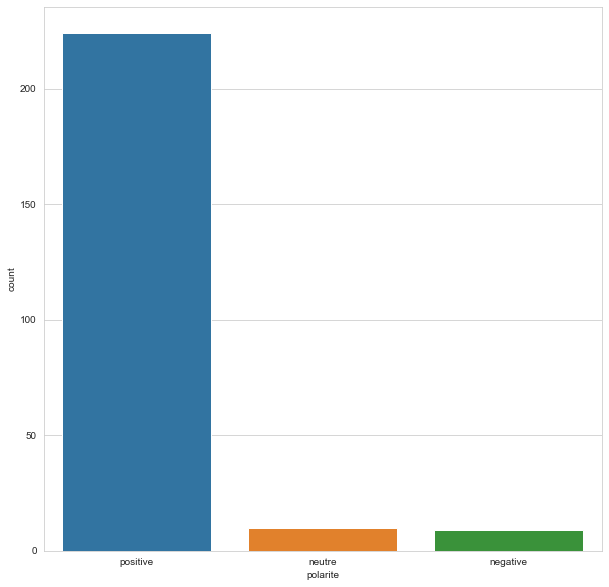

In [43]:
df_polarity_desc1.head()
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.countplot(x="polarite", data=df_polarity_desc1)

In [44]:
pourcentage_positive = round(len(df_polarity_desc1.loc[(df_polarity_desc1.polarite == "positive")])) / len(df_polarity_desc1)
pourcentage_negative = round(len(df_polarity_desc1.loc[(df_polarity_desc1.polarite == "negative")])) / len(df_polarity_desc1)

In [45]:
print(pourcentage_positive)

0.9218106995884774


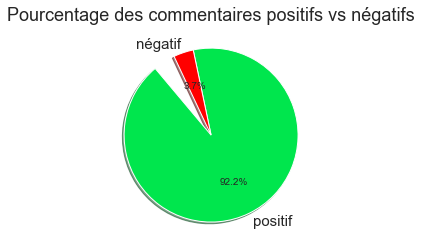

In [46]:
fig1, ax1 = plt.subplots()

plt.title("Pourcentage des commentaires positifs vs négatifs", fontsize=18)
labels = ['positif', 'négatif']
sizes = [pourcentage_positive, pourcentage_negative]
#explode = (0, 0.2)  # seulement détacher le second groupe

patches, texts, autotexts = ax1.pie(sizes,  labels=labels, autopct='%1.1f%%', shadow = True, startangle=130, colors = ['#00e64d', 'r'])
texts[0].set_fontsize(15)
texts[1].set_fontsize(15)

matplotlib.rcParams['text.color'] = 'black'
matplotlib.rcParams["font.size"] = 18
plt.rcParams["figure.figsize"] = [6, 6]

In [47]:
df = pd.read_csv(r"C:\Users\utilisateur\Documents\Projet\ProjetNLP\booking.csv", na_values=['None'], decimal=',')
df_notes = df.iloc[:,7]
#df_notes = pd.DataFrame(data=df_notes)
df_notes.head()

0    10.0
1     9.0
2     9.6
3    10.0
4     9.0
Name: note, dtype: float64

In [48]:
type(df_notes)

pandas.core.series.Series

In [49]:
df_polarity_desc1_polarite = df_polarity_desc1.iloc[:,1]
#df_polarity_desc1_polarite = pd.DataFrame(df_polarity_desc1_polarite)
df_polarity_desc1_polarite.head()

0    positive
1    positive
2    positive
3    positive
4      neutre
Name: polarite, dtype: object

In [50]:
df_corr = pd.concat([df_polarity_desc1_polarite, df_notes], axis = 1)

In [51]:
df_corr.head()

,polarite,note
0,positive,10.0
1,positive,9.0
2,positive,9.6
3,positive,10.0
4,neutre,9.0


In [52]:
df_corr=df_corr.loc[(df_corr.polarite=='positive')|(df_corr.polarite=='negative')]

In [53]:
type(df_corr)

pandas.core.frame.DataFrame

In [54]:
df_corr.head()

,polarite,note
0,positive,10.0
1,positive,9.0
2,positive,9.6
3,positive,10.0
5,positive,7.9


In [55]:


df_corr['polarite'] = np.where(df_corr['polarite'] == 'positive', 1, 0)
df_corr.head()

,polarite,note
0,1,10.0
1,1,9.0
2,1,9.6
3,1,10.0
5,1,7.9


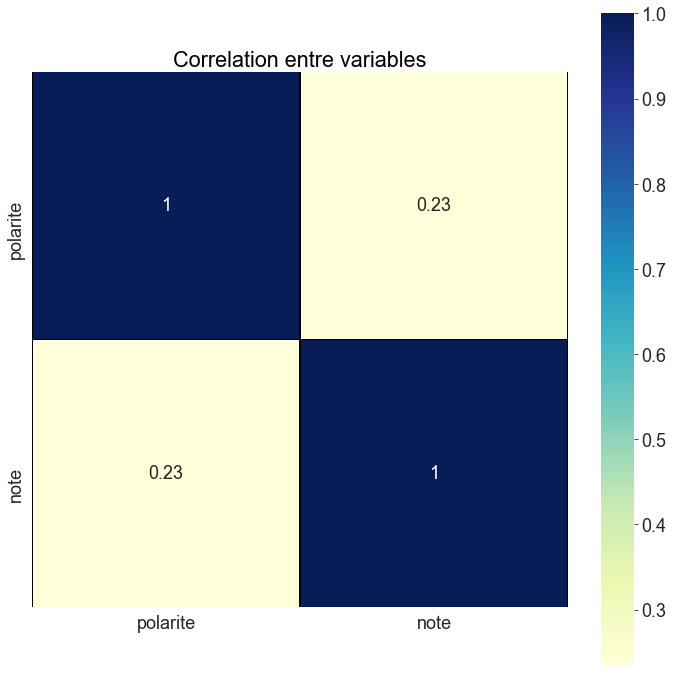

In [56]:
#affichage des corrélations entre variables
#parfaite si r = 1
#très forte si r > 0,8
#forte si r se situe entre 0,5 et 0,8
#d'intensité moyenne si r se situe entre 0,2 et 0,5
#faible si r se situe entre 0 et 0.2

f, ax = plt.subplots(figsize=(12, 12))
plt.title('Correlation entre variables')
sns.heatmap(df_corr.corr(),linewidths=0.25,vmax=1.0, square=True, cmap="YlGnBu", linecolor='black', annot=True);

In [57]:
df_polarity_desc1.head()

,sentiment,polarite
0,0.285000,positive
1,0.354286,positive
2,0.015833,positive
3,0.343750,positive
4,0.000000,neutre


In [58]:
df_polarity_desc1.columns

Index(['sentiment', 'polarite'], dtype='object')

In [59]:
#Transformation des valeurs de la variable polarite en 1 et 0
#pas besoin d'utiliser le module scikit-learn car on peut le faire directement 
df_polarity_desc1['polarite'] = np.where(df_polarity_desc1['polarite'] == 'positive', 1, 0)
df_polarity_desc1 = df_polarity_desc1.reset_index(drop=True)
df_polarity_desc1.head()

,sentiment,polarite
0,0.285000,1
1,0.354286,1
2,0.015833,1
3,0.343750,1
4,0.000000,0


In [60]:
df_polarity_desc1.drop(['sentiment'],1,inplace=True)
df_polarity_desc1.head()

,polarite
0,1
1,1
2,1
3,1
4,0


In [61]:
df21.head()
comments = pd.DataFrame(data=df21)
comments.columns = ['sentences']
comments.head()

,sentences
0,Le confort comme à la maison ! J'ai énormément...
1,"Calme et confortable. Très bon accueil, Hatim ..."
2,Accueil chaleureux - Personnel irréprochable :...
3,"Très correct Merci a Hatim pour l'accueil, trè..."
4,"Très bien L’accueil , la situation de l’établi..."


In [62]:
# fusion des deux datasets en un seul que l'on nommera df
df = pd.concat([df_polarity_desc1, comments], axis = 1)
df.head()

,polarite,sentences
0,1,Le confort comme à la maison ! J'ai énormément...
1,1,"Calme et confortable. Très bon accueil, Hatim ..."
2,1,Accueil chaleureux - Personnel irréprochable :...
3,1,"Très correct Merci a Hatim pour l'accueil, trè..."
4,0,"Très bien L’accueil , la situation de l’établi..."


In [63]:
df.columns=['sentiment', 'sentence']
df.head()

,sentiment,sentence
0,1,Le confort comme à la maison ! J'ai énormément...
1,1,"Calme et confortable. Très bon accueil, Hatim ..."
2,1,Accueil chaleureux - Personnel irréprochable :...
3,1,"Très correct Merci a Hatim pour l'accueil, trè..."
4,0,"Très bien L’accueil , la situation de l’établi..."


In [64]:
df.to_csv('DatasetMachineLearning.csv', index=True)

<h1>3. Machine learning</h1>

In [65]:
X_train, X_test, y_train, y_test = train_test_split(df[["sentence"]], df['sentiment'])

In [66]:
pipe = make_pipeline(CountVectorizer(), TfidfTransformer())
pipe.fit(X_train['sentence'])
feat_train = pipe.transform(X_train['sentence'])
feat_train.shape

(182, 1271)

In [67]:
feat_train.min(), feat_train.max()

(0.0, 0.7101531795816921)

In [68]:
feat_test = pipe.transform(X_test['sentence'])
feat_test.shape

(61, 1271)

In [69]:
dt = DecisionTreeClassifier()
dt.fit(feat_train, y_train)
dt.score(feat_test, y_test)

0.8360655737704918

In [70]:
DecisionTree = dt.fit(feat_train, y_train)

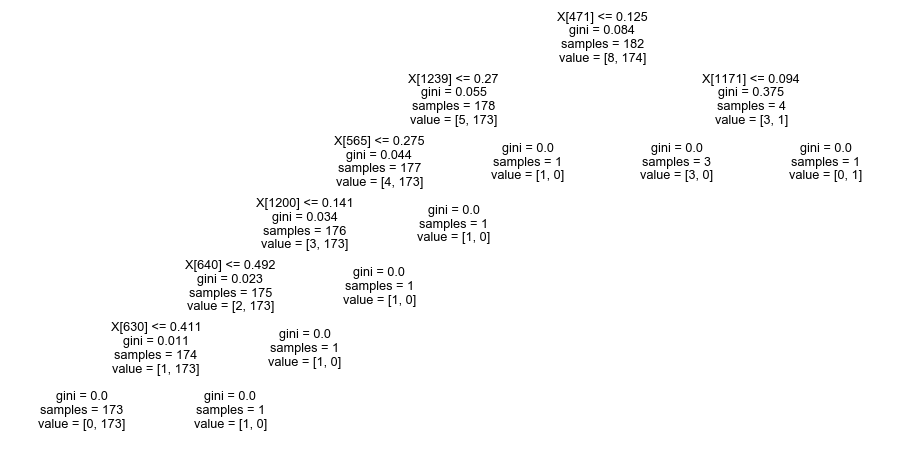

In [71]:
from sklearn import tree
fig=plt.figure(figsize=(16,8))
fig=tree.plot_tree(DecisionTree)
plt.show()

In [72]:
def MatriceConfusion (model):
    y_pred = model.predict(feat_test)
    # Making the Confusion Matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.matshow(cm)
    plt.title('Matrice de confusion', y=1.12)
    plt.colorbar()
    print(cm)
    plt.show()

[[ 0 11]
 [ 0 50]]


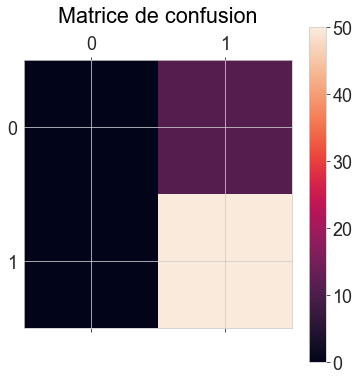

In [73]:
y_pred = MatriceConfusion(DecisionTree)

In [74]:
param_grid = {'max_depth' : [40, 60],
             'n_estimators' : [30, 50, 200]}
grid = GridSearchCV( RandomForestClassifier(), param_grid, cv = 3)

%time grid.fit(feat_train, y_train)
print(grid.best_params_)

model = grid.best_estimator_
yfit = model.predict(feat_test)

Wall time: 3.67 s
{'max_depth': 40, 'n_estimators': 30}


In [75]:
clf = RandomForestClassifier(n_estimators=50, max_depth=40, random_state=42)
clf = clf.fit(feat_train, y_train)
clf.score(feat_test, y_test)

0.819672131147541

In [76]:
score = clf.predict_proba(feat_test)
print(score[0])

[0.1 0.9]


In [77]:
score = clf.predict_proba(feat_test)
fpr, tpr, th = roc_curve(y_test, score[:, 1])

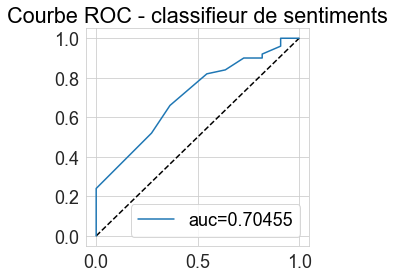

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot([0, 1], [0, 1], 'k--')
aucf = auc(fpr, tpr)
ax.plot(fpr, tpr, label='auc=%1.5f' % aucf)
ax.set_title('Courbe ROC - classifieur de sentiments')
ax.legend();

[[ 0 11]
 [ 0 50]]


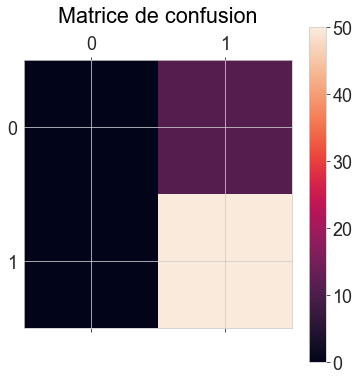

In [79]:
y_pred = MatriceConfusion(clf)

In [80]:
feat_test.shape

(61, 1271)

In [81]:
lr = LogisticRegression()
lr.fit(feat_train, y_train)
lr.score(feat_test, y_test)

0.819672131147541

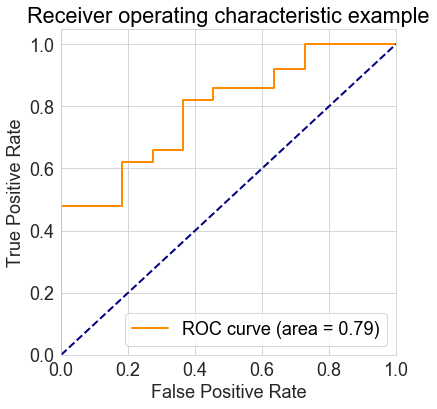

In [82]:
#X_train, X_test, Y_train, Y_test
'''ROC curve'''
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

lr = lr.fit(feat_train, y_train)
y_score = lr.decision_function(feat_test)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

[[ 0 11]
 [ 0 50]]


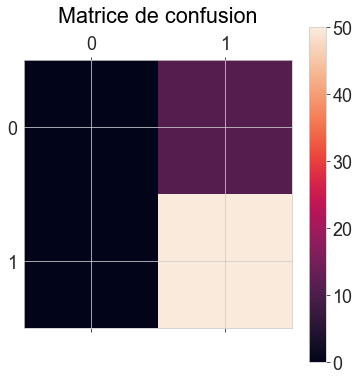

In [83]:
y_pred = MatriceConfusion(lr)

In [84]:
mnb = MultinomialNB()
mnb.fit(feat_train, y_train)
mnb.score(feat_test, y_test)

0.819672131147541

In [85]:
naivebayes = nb.BernoulliNB()
naivebayes.fit(feat_train, y_train)
naivebayes.score(feat_test, y_test)

0.819672131147541

In [86]:
gbc40 = GradientBoostingClassifier()
param_grid = {'max_depth' : [40, 60],
             'n_estimators' : [30, 50, 200]}
grid = GridSearchCV( RandomForestClassifier(), param_grid, cv = 3)

%time grid.fit(feat_train, y_train)
print(grid.best_params_)

model = grid.best_estimator_
yfit = model.predict(feat_test)

Wall time: 3.47 s
{'max_depth': 40, 'n_estimators': 30}


In [87]:
from sklearn.ensemble import GradientBoostingClassifier
gbc40 = GradientBoostingClassifier(n_estimators=30, max_depth=40)
gbc40.fit(feat_train, y_train)
gbc40.score(feat_test, y_test)

0.819672131147541

from sklearn.model_selection import GridSearchCV
    
# defining parameter range
param_grid = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False),'clf-svm__alpha': (1e-2, 1e-3)}
clf = svm.SVC()
clf_grid = GridSearchCV(clf, param_grid, refit = True, verbose = 3,cv=3)
 
# fitting the model for grid search
svm = clf_grid.fit(feat_train, y_train)

In [88]:
from sklearn.model_selection import GridSearchCV
    
# defining parameter range
param_grid = {'C': [10, 50, 100,200],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','sigmoid']
             }
clf = svm.SVC()
clf_grid = GridSearchCV(clf, param_grid, refit = True, verbose = 3,cv=3)
 
# fitting the model for grid search
svm = clf_grid.fit(feat_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........... C=10, gamma=1, kernel=rbf, score=0.951, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........... C=10, gamma=1, kernel=rbf, score=0.951, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........... C=10, gamma=1, kernel=rbf, score=0.967, total=   0.0s
[CV] C=10, gamma=1, kernel=sigmoid ...................................
[CV] ....... C=10, gamma=1, kernel=sigmoid, score=0.951, total=   0.0s
[CV] C=10, gamma=1, kernel=sigmoid ...................................
[CV] ....... C=10, gamma=1, kernel=sigmoid, score=0.951, total=   0.0s
[CV] C=10, gamma=1, kernel=sigmoid ...................................
[CV] ....... C=10, gamma=1, kernel=sigmoid, score=0.967, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] ......... 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ... C=10, gamma=0.001, kernel=sigmoid, score=0.967, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................
[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=0.951, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................
[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=0.951, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................
[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=0.967, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=sigmoid ..............................
[CV] .. C=10, gamma=0.0001, kernel=sigmoid, score=0.951, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=sigmoid ..............................
[CV] .. C=10, gamma=0.0001, kernel=sigmoid, score=0.951, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=sigmoid ..............................
[CV] .. C=10, gamma=0.0001, kernel=sigmoid, score=0.967, total=   0.0s
[CV] C=50, gamma=1, kernel=rbf .......................................
[CV] .

[CV] . C=100, gamma=0.0001, kernel=sigmoid, score=0.967, total=   0.0s
[CV] C=200, gamma=1, kernel=rbf ......................................
[CV] .......... C=200, gamma=1, kernel=rbf, score=0.951, total=   0.0s
[CV] C=200, gamma=1, kernel=rbf ......................................
[CV] .......... C=200, gamma=1, kernel=rbf, score=0.951, total=   0.0s
[CV] C=200, gamma=1, kernel=rbf ......................................
[CV] .......... C=200, gamma=1, kernel=rbf, score=0.967, total=   0.0s
[CV] C=200, gamma=1, kernel=sigmoid ..................................
[CV] ...... C=200, gamma=1, kernel=sigmoid, score=0.951, total=   0.0s
[CV] C=200, gamma=1, kernel=sigmoid ..................................
[CV] ...... C=200, gamma=1, kernel=sigmoid, score=0.951, total=   0.0s
[CV] C=200, gamma=1, kernel=sigmoid ..................................
[CV] ...... C=200, gamma=1, kernel=sigmoid, score=0.967, total=   0.0s
[CV] C=200, gamma=0.1, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.7s finished


In [89]:
print(clf_grid.best_score_.round(2))
print(clf_grid.best_params_)

0.96
{'C': 50, 'gamma': 0.1, 'kernel': 'rbf'}


In [90]:
final_model = clf_grid.best_estimator_

In [91]:
pred_train = final_model.predict(feat_train) 
pred_test = final_model.predict(feat_test)

In [92]:
from sklearn.metrics import classification_report
# print classification report
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00       174

    accuracy                           1.00       182
   macro avg       1.00      1.00      1.00       182
weighted avg       1.00      1.00      1.00       182



In [93]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.82      1.00      0.90        50

    accuracy                           0.82        61
   macro avg       0.41      0.50      0.45        61
weighted avg       0.67      0.82      0.74        61



[[ 0 11]
 [ 0 50]]


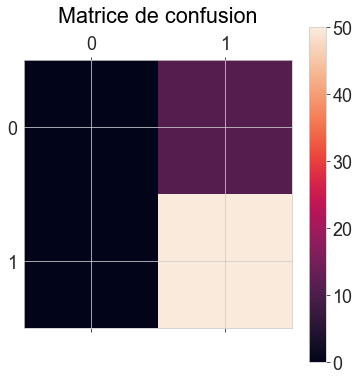

In [94]:
y_pred = MatriceConfusion(svm)

In [95]:
import sklearn.naive_bayes as nb
naivebayes = nb.BernoulliNB()

naivebayes_fit = naivebayes.fit(feat_train, y_train)

In [96]:
pred_train = naivebayes.predict(feat_train)
pred_test = naivebayes.predict(feat_test)

In [97]:
from sklearn import metrics
metrics.accuracy_score(y_train, pred_train)

0.945054945054945

In [98]:
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.96      0.99      0.97       174

    accuracy                           0.95       182
   macro avg       0.48      0.49      0.49       182
weighted avg       0.91      0.95      0.93       182



In [99]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.82      1.00      0.90        50

    accuracy                           0.82        61
   macro avg       0.41      0.50      0.45        61
weighted avg       0.67      0.82      0.74        61



[[ 0 11]
 [ 0 50]]


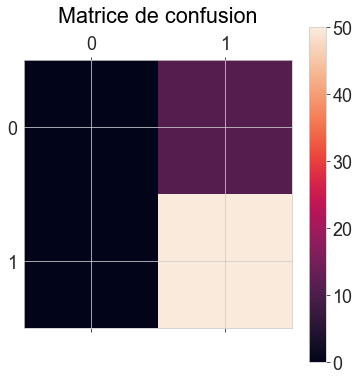

In [100]:
y_pred = MatriceConfusion(naivebayes_fit)

In [101]:
from sklearn.ensemble import GradientBoostingClassifier
gbc40 = GradientBoostingClassifier(n_estimators=200, max_depth=40)
gbc40.fit(feat_train, y_train)
gbc40.score(feat_test, y_test)

0.819672131147541

In [102]:
generated_ngrams = ngrams(word_tokenize(X_train.iloc[0,0]), 3, pad_left=True, pad_right=True)
list(generated_ngrams)[:7]

[(None, None, 'Bien'),
 (None, 'Bien', 'Hôtel'),
 ('Bien', 'Hôtel', 'propre'),
 ('Hôtel', 'propre', 'et'),
 ('propre', 'et', 'bien'),
 ('et', 'bien', 'équipé'),
 ('bien', 'équipé', '.')]

In [103]:
pipe2 = make_pipeline(CountVectorizer(ngram_range=(1, 2)),
                      TfidfTransformer())
pipe2.fit(X_train['sentence'])
feat_train2 = pipe2.transform(X_train['sentence'])
feat_train2.shape

(182, 5131)

In [104]:
cl = pipe2.steps[0]
cl[1].get_feature_names()[:10]

['00',
 '00 hôtel',
 '00 par',
 '10',
 '10 00',
 '10 min',
 '100',
 '100 les',
 '100 minutes',
 '110']

In [105]:
feat_test2 = pipe2.transform(X_test['sentence'])

In [106]:
clf2 = LogisticRegression()
clf2.fit(feat_train2, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [107]:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [108]:
clf2.score(feat_test2, y_test)

0.819672131147541

In [109]:
pipe_svd = make_pipeline(CountVectorizer(), TruncatedSVD(n_components=300))
pipe_svd.fit(X_train['sentence'])
feat_train_svd = pipe_svd.transform(X_train['sentence'])
feat_train_svd.shape

(182, 182)

In [110]:
clf_svd = RandomForestClassifier(n_estimators=50, max_depth=40, random_state=42)
clf_svd.fit(feat_train_svd, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [111]:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [112]:
feat_test_svd = pipe_svd.transform(X_test['sentence'])
clf_svd.score(feat_test_svd, y_test)

0.819672131147541

In [113]:
lr_svd = LogisticRegression()
lr_svd.fit(feat_train_svd, y_train)
lr_svd.score(feat_test_svd, y_test)

0.819672131147541

In [114]:
pipe_svd_tfidf = make_pipeline(CountVectorizer(),
                     TfidfTransformer(),
                     TruncatedSVD(n_components=300))
pipe_svd_tfidf.fit(X_train['sentence'])
feat_train_svd_tfidf = pipe_svd_tfidf.transform(X_train['sentence'])

clf_svd_tfidf = LogisticRegression()
clf_svd_tfidf.fit(feat_train_svd_tfidf, y_train)

feat_test_svd_tfidf = pipe_svd_tfidf.transform(X_test['sentence'])
clf_svd_tfidf.score(feat_test_svd_tfidf, y_test)

0.819672131147541

In [115]:
sentance = [list(tokenize(s, deacc=True, lower=True)) for s in X_train['sentence']]
sentance[0]

['bien',
 'hotel',
 'propre',
 'et',
 'bien',
 'equipe',
 'personnel',
 'gentil',
 'et',
 'correcte',
 'le',
 'petit',
 'dejeuner',
 'est',
 'trop',
 'cher',
 'pour',
 'ce',
 'qu',
 'on',
 'offre']

In [116]:
model = word2vec.Word2Vec(sentance, size=300, window=20,
                          min_count=2, workers=1, iter=100)
model.corpus_count

182

In [117]:
vocab = model.wv.vocab
list(vocab)[:5]

['bien', 'hotel', 'propre', 'et', 'equipe']

In [118]:
model.save('trained_word2vec.bin')

In [119]:
model.wv['exceptionnel'].shape, model.wv['exceptionnel'][:10]

((300,),
 array([ 0.24096775, -0.29746702,  0.12214518, -0.15439296, -0.33198038,
        -0.37774596, -0.11498233, -0.13499989,  0.08542626,  0.2953039 ],
       dtype=float32))

In [120]:
def get_vect(word, model):
    try:
        return model.wv[word]
    except KeyError:
        return numpy.zeros((model.vector_size,))

def sum_vectors(phrase, model):
    return sum(get_vect(w, model) for w in phrase)

def word2vec_features(X, model):
    feats = numpy.vstack([sum_vectors(p, model) for p in X])
    return feats

wv_train_feat = word2vec_features(X_train["sentence"], model)
wv_train_feat.shape

(182, 300)

In [121]:
clfwv = LogisticRegression(solver='lbfgs', max_iter=1000)
clfwv.fit(wv_train_feat, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [122]:
wv_test_feat = word2vec_features(X_test["sentence"], model)

In [123]:
clfwv.score(wv_test_feat, y_test)

0.819672131147541

In [124]:
words = list(sorted(model.wv.vocab))
words[:10]

['a',
 'acces',
 'accessible',
 'accueil',
 'accueillant',
 'adorables',
 'adresse',
 'affaires',
 'agreable',
 'ahmed']

In [125]:
subset = ['exceptionnel', 'client', words[3], words[4], words[5]]
rows = []
for w in subset:
    for ww in subset:
        rows.append(dict(w1=w, w2=ww, d=model.wv.similarity(w, ww)))
import pandas
pandas.DataFrame(rows).pivot("w1", "w2", "d")

KeyError: "word 'client' not in vocabulary"

In [ ]:
# y variable dépendante et X variables indépendantes
#X = df.iloc[:, df.columns !='polaritecomments'].values
#y = df.iloc[:, 5].values

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
#print (X_train.shape,y_train.shape)
#print (X_test.shape, y_test.shape)

In [ ]:
#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

In [ ]:
#train = pd.DataFrame(X_train)

In [ ]:
#train.hist(figsize=(13,50),color='blue',bins=40,layout=(8,3))
#plt.show()

In [ ]:
#param_grid = {'max_depth' : [3, 10, 15],
#    'random_state': [0, 42],
#             'n_estimators' : [10, 50]}
#grid = GridSearchCV( RandomForestClassifier(), param_grid)

#%time grid.fit(X_train, y_train)
#print(grid.best_params_)

#model = grid.best_estimator_
#yfit = model.predict(X_test)

In [ ]:
#weights = (y == 0).sum() / (1.0 * (y == 1).sum())

In [ ]:
#def get_score(model,X_train,X_test,y_train,y_test):
    #model.fit(X_train,y_train)
    #return model.score(X_test,y_test)

In [ ]:
kf = KFold(n_splits=3)

LR = LogisticRegression()
SVM = SVC()
NB = nb.BernoulliNB()
DTC = DecisionTreeClassifier(max_depth = 5, random_state= 42)
RF = RandomForestClassifier(max_depth = 5, n_estimators= 10, random_state= 42)
XGBC = XGBClassifier(max_depth = 5, scale_pos_weight = weights, \
                n_jobs = 4)

logis=list()
svm=list()
nb=list()
arb=list()
rfl=list()
clf=list()

for index_train, index_test in kf.split(d_model):
    X_train, X_test, y_train, y_test = X[index_train], X[index_test], y[index_train], y[index_test]
    logis.append(get_score(LR, X_train, X_test, y_train, y_test))
    svm.append(get_score(SVM, X_train, X_test, y_train, y_test))
    nb.append(get_score(NB, X_train, X_test, y_train, y_test))
    arb.append(get_score(DTC, X_train, X_test, y_train, y_test))
    rfl.append(get_score(RF, X_train, X_test, y_train, y_test))
    clf.append(get_score(XGBC, X_train, X_test, y_train, y_test))
    
print(np.mean(logis))
print(np.mean(svm))
print(np.mean(arb))
print(np.mean(rfl))
print(np.mean(clf))

In [ ]:
# y variable dépendante et X variables indépendantes
X = d_model.iloc[:, d_model.columns !='isFraud']
Y = d_model.iloc[:, 5]

X_t = pd.DataFrame(X_train)
feature_importances = pd.DataFrame(RF.feature_importances_, index = X.columns,columns=['importance']).sort_values('importance',ascending=False)
feature_importances

In [ ]:
features = X.columns
importances=RF.feature_importances_
indices=np.argsort(importances)
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('importance du score');
plt.ylabel('variables indépendantes');
plt.title('Ordre d\'importance des variables indépendantes');
plt.show()

In [ ]:
def MatriceConfusion (model):
    y_pred = model.predict(X_test)
    # Making the Confusion Matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.matshow(cm)
    plt.title('Matrice de confusion', y=1.12)
    plt.colorbar()
    print(cm)
    plt.show()

In [ ]:
y_pred = MatriceConfusion(LR)

In [ ]:
#NaiveBayes = muticlasses
#SVM = multiclasses